# Imports

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [28]:
df = pd.read_spss('../data/CCAM SPSS Data 2008-2018.sav')
df.to_csv('../data/CCAM SPSS Data 2008-2018.csv', index=False)
df = pd.read_csv('../data/CCAM SPSS Data 2008-2018.csv')

In [29]:
geo = pd.read_csv('../data/YCOM6.0_2021_Data_.csv', encoding='latin-1')

In [30]:
df.drop('case_ID', axis=1, inplace=True)

## Review Target Column

In [31]:
df.happening.value_counts(normalize=True)

Yes           0.665373
Don't know    0.170325
No            0.161135
Refused       0.003167
Name: happening, dtype: float64

In [32]:
# drop Refused
df = df[df.happening != "Refused"]

In [33]:
df.happening.value_counts(normalize=True)

Yes           0.667487
Don't know    0.170866
No            0.161647
Name: happening, dtype: float64

# Initial Inspection 

In [6]:
def columns_info(df):
    columns_df = pd.DataFrame({'nulls': [df[col].isna().sum() for col in df.keys()], 
                         'dtype': [df[col].dtype for col in df.keys()], 
                         'nunique_values': [df[col].nunique() for col in df.keys()], 
                         'unique_values': [df[col].unique()for col in df.keys()], 
                         'value_counts': [df[col].value_counts() for col in df.keys()]}, 
                         index=[col for col in df.keys()])
    return columns_df

# Function to Inspect Column
def col_info(col):
    return pd.DataFrame({'nulls': df[col].isna().sum(), 
                         'dtype': df[col].dtype,
                         'nunique': df[col].nunique(), 
                         'unique_values': [df[col].unique()], 
                         'value_counts': [df[col].value_counts()]}, 
                         index=[col])

In [7]:
columns_info(df)

,nulls,dtype,nunique_values,unique_values,value_counts
wave,0,object,19,"[Nov 2008, Jan 2010, Jun 2010, May 2011, Nov 2...",Nov 2008 2164 Oct 2015 1330 Oct 2017 ...
year,0,int64,10,"[2008, 2010, 2011, 2012, 2013, 2014, 2015, 201...",2015 2593 2017 2570 2016 2430 2018 ...
weight_wave,0,float64,8230,"[0.5400000000000001, 0.85, 0.49, 0.29, 1.29, 2...",0.5400 80 0.6100 78 0.4200 77 0.4100 ...
weight_aggregate,0,float64,11648,"[0.2944021792003114, 0.4634108376301197, 0.267...",0.299854 30 0.294402 29 0.316210 29 0...
happening,0,object,4,"[Yes, Don't know, No, Refused]",Yes 14915 Don't know 3818 No ...
cause_original,0,object,5,"[Caused mostly by human activities, Caused mos...",Caused mostly by human activities ...
cause_other_text,20426,object,1390,"[nan, both of the above, a combination of huma...",both ...
cause_recoded,0,object,7,"[Caused mostly by human activities, Caused mos...",Caused mostly by human activities ...
sci_consensus,1330,object,5,[Most scientists think global warming is happe...,Most scientists think global warming is happen...
worry,0,object,5,"[Somewhat worried, Not very worried, Not at al...",Somewhat worried 9049 Not very worried ...


---
---

# Eploratory Data Analysis

### Happening

In [8]:
df.happening.value_counts().to_frame()

,happening
Yes,14915
Don't know,3818
No,3612
Refused,71


### `happening` (target)

''

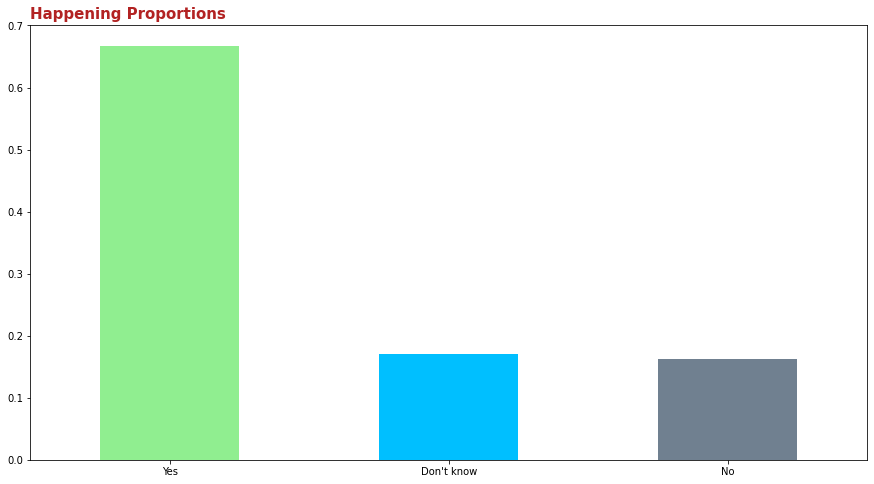

In [340]:
fig, ax = plt.subplots(figsize=(15, 8))

df.happening.value_counts(normalize=True).plot(kind='bar', 
                                               color=['lightgreen', 
                                                      'deepskyblue', 
                                                      'slategrey'])

ax.set_title('happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')

plt.xticks(rotation = 0)

ax.set_title('Happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')
;

### Wave

In [12]:
df.wave = [' '.join(wave.split(' ')[::-1]) for wave in df.wave]

In [13]:
df.wave.value_counts().sort_index().to_frame()

,wave
2008 Nov,2164
2010 Jan,1001
2010 Jun,1024
2011 May,1010
2011 Nov,1000
2012 Mar,1008
2012 Sep,1061
2013 Apr,1045
2013 Nov,830
2014 Apr,1013


In [14]:
df.wave.value_counts().sort_index()[1:].values.mean()

1125.111111111111

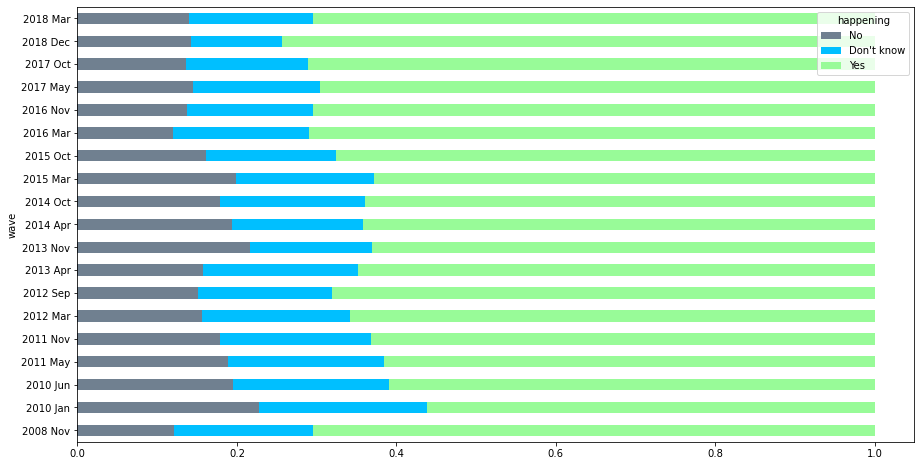

In [341]:
df.groupby('wave')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh',
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen']);

**Wave**

Observation
- The first poll had the largest number of responses. 
- Each poll afterwards had 1125 responses on average. 
- It seems like the number of people in each poll was divided in half after the first year. 

### Year

**Proportion of Believe in Climate Change over 2008 - 2018**

''

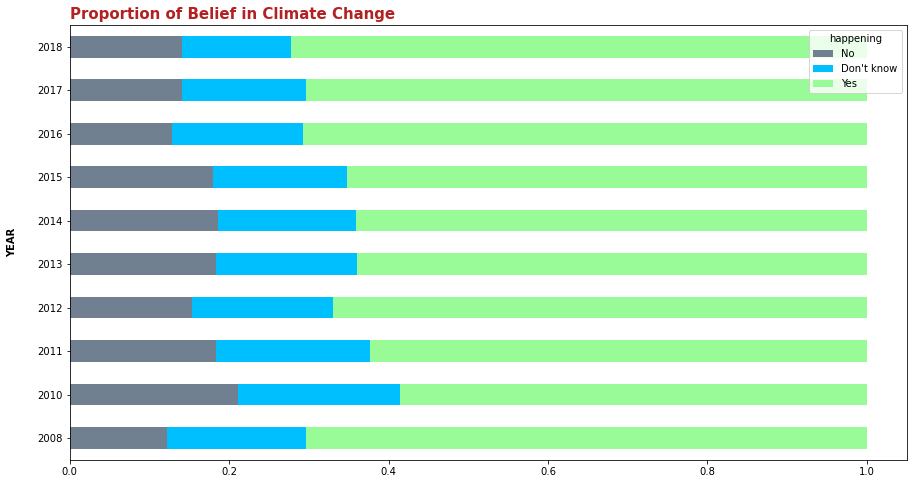

In [342]:
fig, ax = plt.subplots(figsize=(10, 10))

df.groupby('year')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh', 
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen'], 
          ax=ax)

ax.set_title('Proportion of Belief in Climate Change', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left')
ax.set_ylabel('YEAR', weight='bold', labelpad=20)

;

In [18]:
df.year.value_counts().to_frame()

,year
2015,2593
2017,2570
2016,2430
2018,2392
2014,2288
2008,2164
2012,2069
2010,2025
2011,2010
2013,1875


In [343]:
df.groupby('year')['happening'].value_counts(normalize=True).to_frame().unstack()

happening                    
happening Don't know        No       Yes
year                                    
2008        0.174478  0.121578  0.703944
2010        0.202978  0.211414  0.585608
2011        0.193124  0.183519  0.623357
2012        0.176699  0.153398  0.669903
2013        0.176219  0.183717  0.640064
2014        0.174103  0.185477  0.640420
2015        0.167759  0.179715  0.652526
2016        0.164198  0.128807  0.706996
2017        0.156031  0.140467  0.703502
2018        0.135926  0.141363  0.722710

**Proportion of Believe in Climate Change over 2008 - 2018**

Observation
- 

### Weight Wave

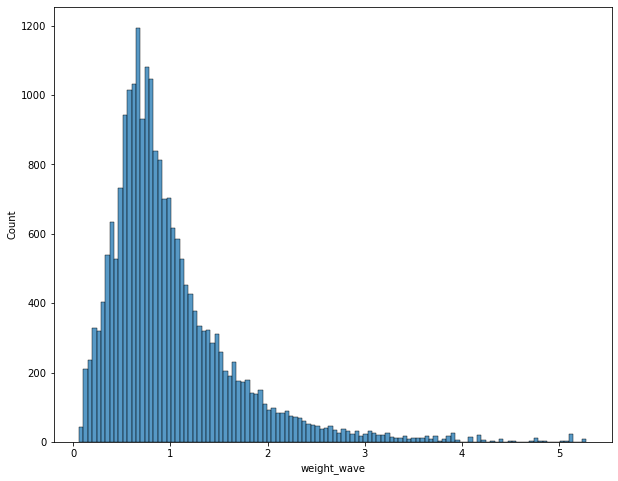

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df, x='weight_wave', ax=ax);

In [21]:
df.weight_wave.describe()

count    22416.000000
mean         0.999984
std          0.660911
min          0.060000
25%          0.585600
50%          0.825000
75%          1.223250
max          5.280000
Name: weight_wave, dtype: float64

In [22]:
df.groupby('year')['weight_wave'].value_counts().to_frame()

weight_wave
year weight_wave             
2008 0.5500                30
     0.5400                29
     0.5800                29
     0.5700                28
     0.6100                28
...                       ...
2018 3.2767                 1
     3.2917                 1
     3.4013                 1
     3.6874                 1
     3.7050                 1

[11077 rows x 1 columns]

**weight_wave**

Observation
- Not sure how they calculated the sampling weight for different waves of polling 
- I don't see how this feature would be useful in modeling or analyzing relationships between features and target

### Cause Original
Assuming global warming is happening do you think it is...

In [344]:
x = df.groupby('happening')['cause_original'].value_counts().to_frame().unstack().T
x['num_per_row'] = x.sum(axis=1).values
x

happening                                                          Don't know  \
               cause_original                                                   
cause_original Caused mostly by human activities                         1119   
               Caused mostly by natural changes in the environ...        1874   
               None of the above because global warming isn't ...         359   
               Other (Please specify)                                     436   
               Refused                                                     30   

happening                                                            No  \
               cause_original                                             
cause_original Caused mostly by human activities                    342   
               Caused mostly by natural changes in the environ...  1854   
               None of the above because global warming isn't ...  1105   
               Other (Please specify)                               303   
               Refused                                                8   

happening                                                            Yes  \
               cause_original                                              
cause_original Caused mostly by human activities                   10068   
               Caused mostly by natural changes in the environ...   3421   
               None of the above because global warming isn't ...     30   
               Other (Please specify)                               1384   
               Refused                                                12   

happening                                                          num_per_row  
               cause_original                                                   
cause_original Caused mostly by human activities                         11529  
               Caused mostly by natural changes in the environ...         7149  
               None of the above because global warming isn't ...         1494  
               Other (Please specify)                                     2123  
               Refused                                                      50

''

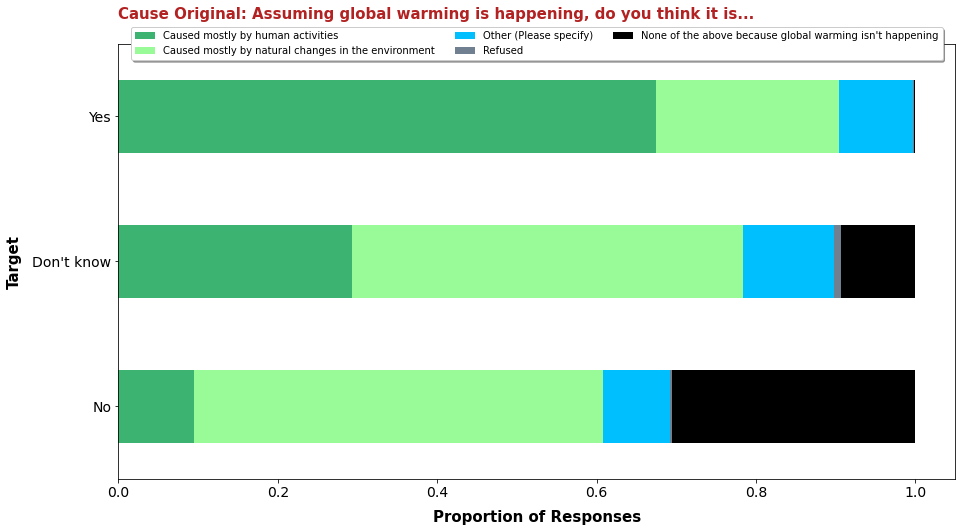

In [352]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_original'].value_counts(normalize=True)\
.unstack().loc[['No', "Don't know", 'Yes']].T\
          .loc[['Caused mostly by human activities',
               'Caused mostly by natural changes in the environment',
               'Other (Please specify)',
               'Refused',
               "None of the above because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            fontsize=14,
                                            color=['mediumseagreen', 
                                                   'palegreen',
                                                   'deepskyblue', 
                                                   'slategrey',
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Original: Assuming global warming is happening, do you think it is...', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Proportion of Responses', weight='bold', fontsize=15, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Original**

Observation 
- 95 people refused to answer this question 
- For each `happening` subgroup, some people "None of the above because global warming isn't happening." 30 people who said "Yes" to `happening` selected this response for this question 
- For the 'No' subgroup of `happening`, 2,960 people selected either of the two choices that state what the cause of global warming is. This is a contradiction. 
- Drop "Refused" when ordinal encoding feature
    1. "None of the above because global warming isn't happening"
    2. "Other (Please specify)"
    3. "Caused mostly by natural changes in the environment"
    4. "Caused mostly by human activities"

In [45]:
df.drop(columns=['cause_original'], axis=1, inplace=True)

### Cause Other Text

[Other - Specify] Assuming global warming is happening, do you think it is...

- This feature had empty strings that I converted to np.nan
- Were these questions only answered if cause_original responses was "Other"

In [353]:
# Number of "Other (Please specify)" in cause_original
df[df.cause_original == 'Other (Please specify)']['cause_original'].count()

2123

In [354]:
# People who answer 'other' in 1st question, but didn't specify here as directed
df.cause_other_text.fillna('', inplace=True)

df[(df.cause_original == 'Other (Please specify)') & 
   (df.cause_other_text == '')]['cause_other_text'].count()

136

In [355]:
# Responses to cause_original for people who didn't answer this question 
df[df.cause_other_text == '']['cause_original'].value_counts().to_frame()

,cause_original
Caused mostly by human activities,11529
Caused mostly by natural changes in the environment,7149
None of the above because global warming isn't happening,1494
Other (Please specify),136
Refused,50


In [356]:
df.cause_other_text.value_counts(dropna=False)

                                                           20358
both                                                         116
Both                                                          60
both of the above                                             29
combination of both                                           23
                                                           ...  
combo of natural and human                                     1
I'm not sure                                                   1
natural changes somewhat influenced by human activities        1
caused by both human and enviroment                            1
it is caused by both                                           1
Name: cause_other_text, Length: 1390, dtype: int64

In [357]:
# How many people did answer this question 
df[df.cause_other_text != '']['happening'].count()

1987

In [33]:
df.cause_other_text.nunique()

1390

**Cause Other Text**

- there are a 2126 unique answers. Many of them mean the same thing and could be grouped. It could be interesting to investigate further and get more ideas about the data.  
    - lots of people said it was both, meaning both human activity and natural causes 
    - lots of people reference God
    - lot of people said they don't know 
- 1991 people responded to this question
- 135 people who answered "Other" for `cause_original` did not specify here as instructed
- Because only 9% of people answered this question, and it overlaps with `cause_original`, this feature is unlikely to be useful

In [44]:
df.drop(columns=['cause_other_text'], axis=1, inplace=True)

### Cause Recorded

Assuming global warming is happening, do you think it is... (Recoded to include open-ends)

- it seems this feature was created from combining both `cause_original` and `cause_original_text`

In [358]:
# df.cause_recoded.value_counts().to_frame()

x = df.groupby('happening')['cause_recoded'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)
x.astype(dtype=int, errors='ignore')

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/2947318618.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening,cause_recoded,Don't know,No,Yes,(sum)
0,Caused by human activities and natural changes,227,46,1093,1366
1,Caused mostly by human activities,1127,347,10142,11616
2,Caused mostly by natural changes in the enviro...,1931,1999,3498,7428
3,Don't know,71,5,46,122
4,Neither because global warming isn't happening,363,1118,30,1511
5,Other (Please specify),69,89,94,252
6,Refused,30,8,12,50
(sum),0,3818,3612,14915,22345


''

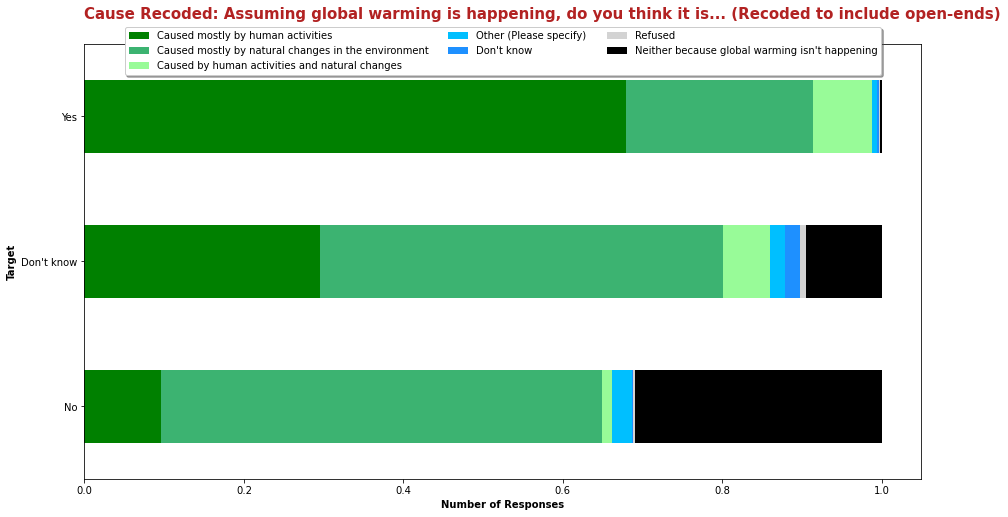

In [359]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_recoded'].value_counts(normalize=True).unstack()\
.loc[['No', "Don't know", 'Yes']].T\
.loc[['Caused mostly by human activities', 
      'Caused mostly by natural changes in the environment', 
      'Caused by human activities and natural changes', 
      'Other (Please specify)', 
      "Don't know", 
      'Refused', 
      "Neither because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True, 
                                            color=['g', 
                                                   'mediumseagreen', 
                                                   'palegreen', 
                                                   'deepskyblue',
                                                   'dodgerblue', 
                                                   'lightgrey', 
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Recoded: Assuming global warming is happening, do you think it is... (Recoded to include open-ends)', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold')
ax.set_xlabel('Number of Responses', weight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Recoded**

Observation 
- "Don't Know" and "Caused by human activities and natural changes" were added. 
- "Refused" had no change between `cause_original` and `cause_original_text`
- Differences in answers from `cause_original` = "Other (Please specify) and `cause_recoded`
    - 17 people answered "Neither because global warming isn't happening" here
    - 1647 people answered either the 1st 2 questions meaning they believe in Global Warming 
    - 252 people still responded "Other (Please specify)" 

### SCI Concensus 

Scientist Consensus: Which comes closest to your own view?
- Not asked in Oct 2015

In [41]:
# Number of Nulls in sci_consensus from "2016 Oct"
df.sci_consensus.isnull().sum()

1330

In [360]:
x = df.groupby('happening')['sci_consensus'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/2592813390.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening,sci_consensus,Don't know,No,Yes,(sum)
0,0,216,215,899,1330
1,Don't know enough to say,1485,392,1711,3588
2,Most scientists think global warming is happening,440,230,8715,9385
3,Most scientists think global warming is not ha...,58,515,134,707
4,Refused,15,11,19,45
5,There is a lot of disagreement among scientist...,1604,2249,3437,7290
(sum),0,3818,3612,14915,22345


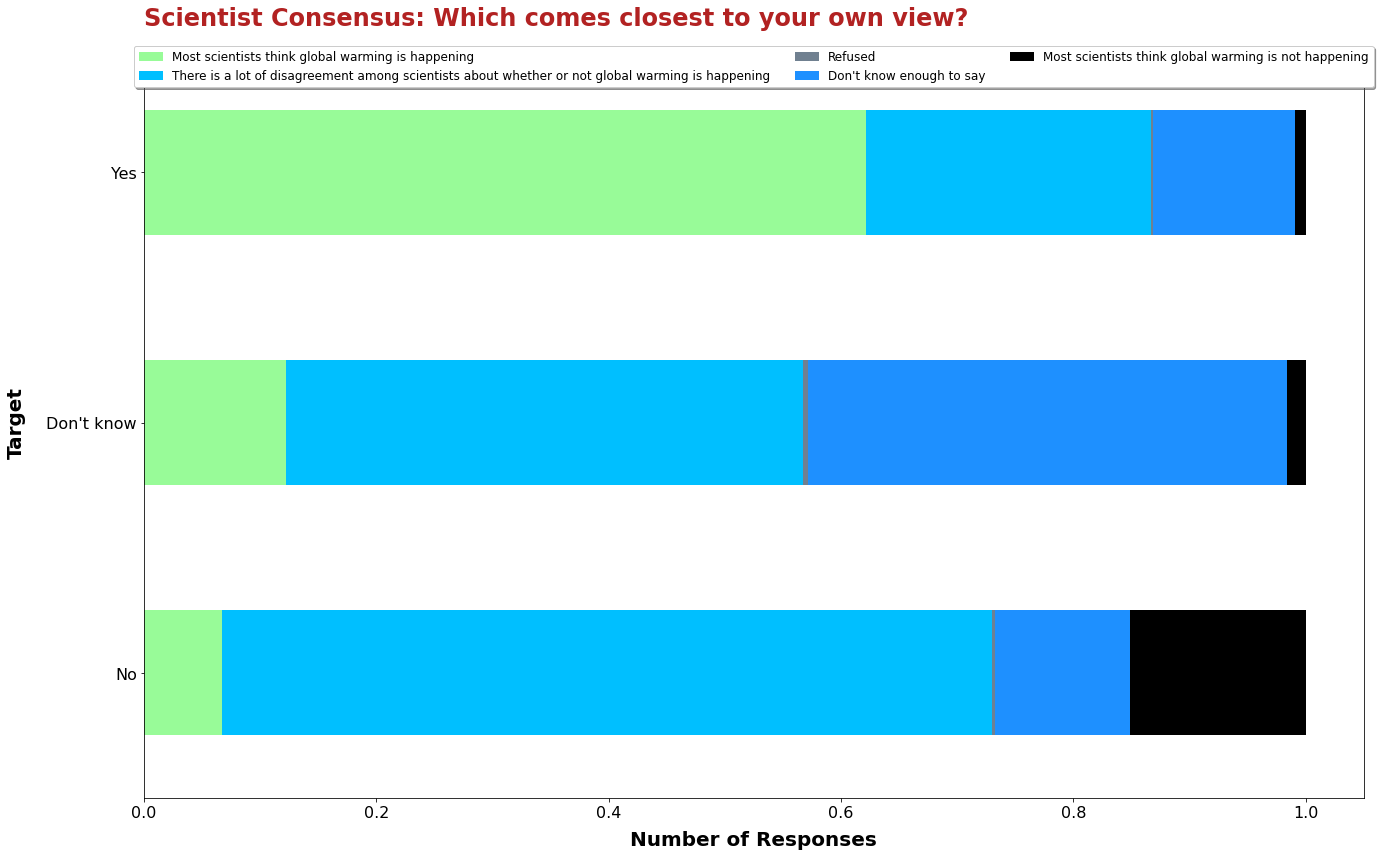

In [361]:
fig, ax = plt.subplots(figsize=(20, 12))

df.groupby('happening')['sci_consensus'].value_counts(normalize=True).unstack().loc[['No', "Don't know", 'Yes']].T\
.loc[['Most scientists think global warming is happening', 
      'There is a lot of disagreement among scientists about whether or not global warming is happening', 
      'Refused',
      "Don't know enough to say", 
      'Most scientists think global warming is not happening']].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            color=['palegreen', 
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'dodgerblue',
                                                   'black'], 
                                           label=('1', '2'), 
                                           fontsize=16)
ax.set_title('Scientist Consensus: Which comes closest to your own view?', 
             fontsize=24, fontweight='bold', color='firebrick', loc='left', pad=22)
ax.set_ylabel('Target', weight='bold', fontsize=20, labelpad=20)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=20, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [44]:
df.groupby('target')['sci_consensus'].value_counts().to_frame()

sci_consensus
target sci_consensus                                                    
0      There is a lot of disagreement among scientists...           3859
       Don't know enough to say                                     1885
       Most scientists think global warming is happening             682
       Most scientists think global warming is not hap...            573
       Refused                                                        71
1      Most scientists think global warming is happening            8715
       There is a lot of disagreement among scientists...           3437
       Don't know enough to say                                     1711
       Most scientists think global warming is not hap...            134
       Refused                                                        19

**Science Consensus**

Observation 
- 90 people Refused to answer this question 
- This question is the least likely to leak data into the model
- 1330 Nulls for this feature from 2015 Oct
    - possible to impute with KNNImputer

### Worry

How worried are you about global warming?

In [362]:
x = df.groupby('happening')['worry'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/2187703950.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening,worry,Don't know,No,Yes,(sum)
0,Not at all worried,845,2207,789,3841
1,Not very worried,1847,1221,2930,5998
2,Refused,17,7,18,42
3,Somewhat worried,1050,162,7822,9034
4,Very worried,59,15,3356,3430
(sum),0,3818,3612,14915,22345


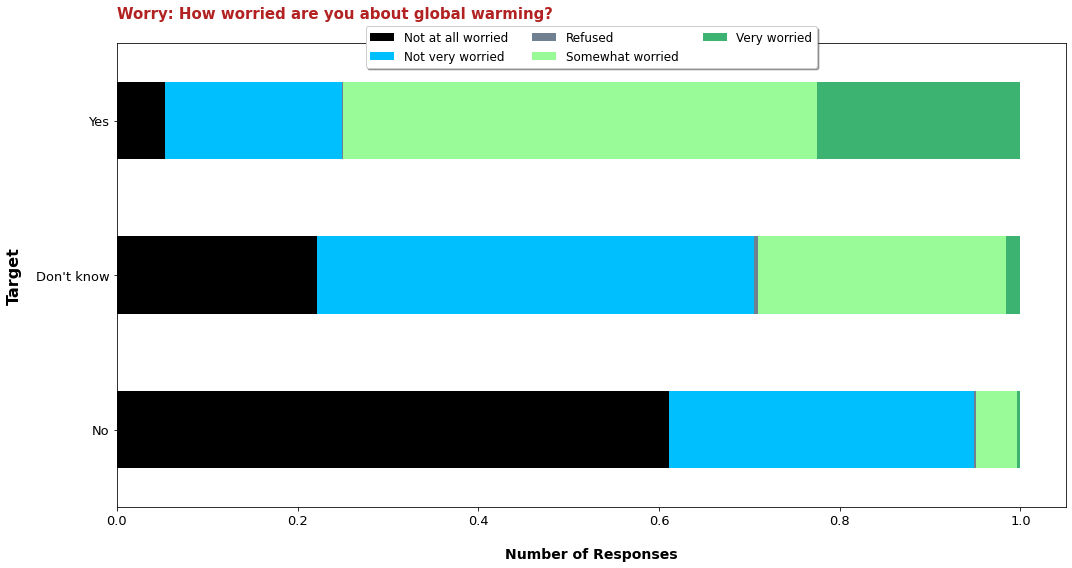

In [363]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['worry'].value_counts(dropna=False, normalize=True).unstack().loc[['No', "Don't know", 'Yes']] \
                                      .plot(kind='barh', 
                                            ax=ax,
                                            stacked=True,
                                            color=['black',
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'palegreen', 
                                                   'mediumseagreen',
                                                   'g'], 
                                           label=('1', '2'), 
                                           fontsize=13)
ax.set_title('Worry: How worried are you about global warming?', 
             fontsize=15, fontweight='bold', color='firebrick', loc='left', pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=16, labelpad=14)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=14, labelpad=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

**Worry**

Observation 
- 83 people Refused 
- For `happening` = "Not Yes"
    - 68 Refused
    - 3056 Not at all worried 
    - 19292 expressed some level of worry
- This feature might be misleading for predicting the target
- This feature could be reduced to binary (worry_True, worry_False) for OHE
- Could also reduce to 3 subgroups (not_worried, worried, very_worried)

## Harm Series of Questions
The following five risk perception questions were asked together as a set
- harm_personally
- harm_US
- harm_dev_coutnries
- harm_future_gen
- harm_plants_animals

### Harm Personally
How much do you think global warming will harm: You personally

In [364]:
x = df.groupby('happening')['harm_personally'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/2848853250.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening,harm_personally,Don't know,No,Yes,(sum)
0,A great deal,131,32,2396,2559
1,A moderate amount,599,180,4796,5575
2,Don't know,1092,254,1190,2536
3,Not at all,1045,2618,1938,5601
4,Only a little,927,513,4574,6014
5,Refused,24,15,21,60
(sum),0,3818,3612,14915,22345


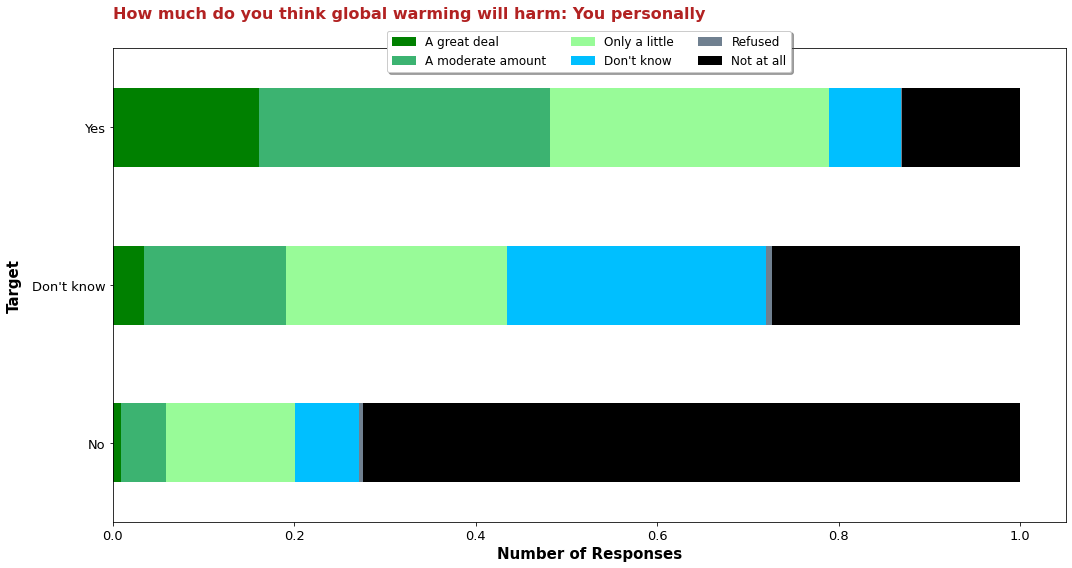

In [365]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_personally'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True,
                              fontsize=13, 
                            color=['g', 
                                   'mediumseagreen', 
                                   'palegreen',
                                   'deepskyblue',
                                   'slategrey',
                                   'black'],
                           label=('1', '2'))
ax.set_title('How much do you think global warming will harm: You personally', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=30)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [50]:
df.groupby('target')['harm_personally'].value_counts().to_frame()

harm_personally
target harm_personally                   
0      Not at all                    3666
       Only a little                 1450
       Don't know                    1351
       A moderate amount              785
       A great deal                   167
       Refused                         82
1      A moderate amount             4796
       Only a little                 4574
       A great deal                  2396
       Not at all                    1938
       Don't know                    1190
       Refused                         21

**Harm Personally**

Observation 
- 103 people "Refused"
- This will be a good predictor 

### Harm US
How much do you think global warming will harm: People in the United States

In [366]:
x = df.groupby('happening')['harm_US'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/404011177.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening,harm_US,Don't know,No,Yes,(sum)
0,A great deal,245,57,4767,5069
1,A moderate amount,847,288,5583,6718
2,Don't know,1148,309,1088,2545
3,Not at all,613,2268,752,3633
4,Only a little,939,670,2689,4298
5,Refused,26,20,36,82
(sum),0,3818,3612,14915,22345


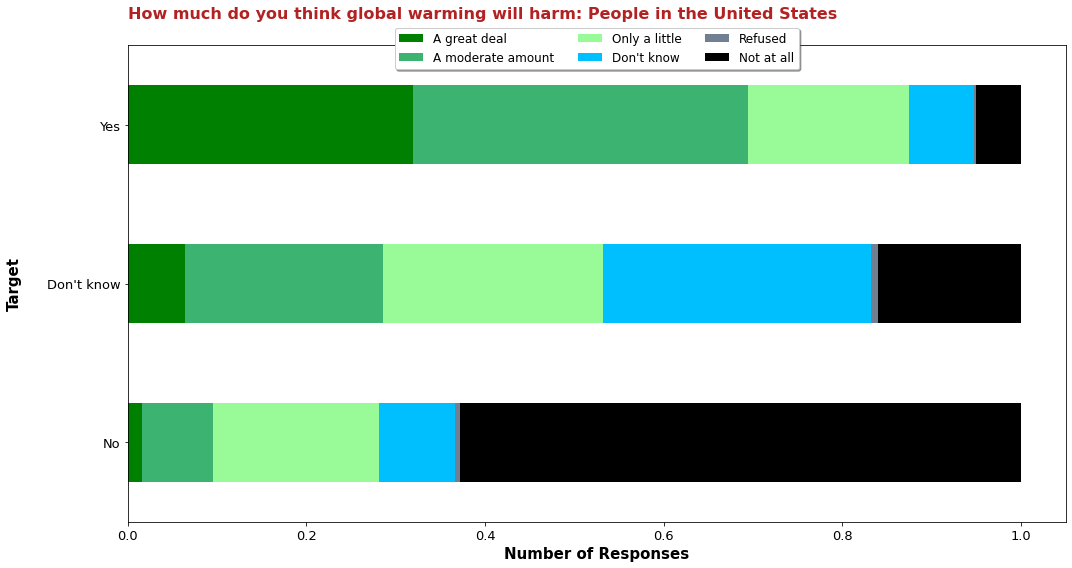

In [367]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_US'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True, 
                              fontsize=13,
                              color=['g', 
                                     'mediumseagreen', 
                                     'palegreen',
                                     'deepskyblue',
                                     'slategrey',
                                     'black'],
                              label=('1', '2'))
ax.set_title('How much do you think global warming will harm: People in the United States', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=27)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=25)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

---
---

**Rows with too many questions answered "Refused"**

In [59]:
# df.happening.value_counts()

Yes           14915
Don't know     3818
No             3612
Refused          71
Name: happening, dtype: int64

In [60]:
# # Cause of Global Warming 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') 
#   ]['target'].value_counts()

0    83
1    12
Name: target, dtype: int64

In [61]:
# # People who "Refused" all Harm series questions 
# df[(df.harm_personally == 'Refused') & 
#    (df.harm_US == 'Refused') & 
#    (df.harm_dev_countries == 'Refused') & 
#    (df.harm_future_gen == 'Refused') & 
#    (df.harm_plants_animals == 'Refused') 
#   ]['target'].value_counts()

0    70
1     8
Name: target, dtype: int64

In [62]:
# # Cause of Global Warming 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') 
#   ]['target'].value_counts()

0    83
1    12
Name: target, dtype: int64

In [63]:
# # People who "Refused" Cause questions and all Harm series questions 
# df[(df.cause_original == 'Refused') &
#    (df.cause_recoded == 'Refused') &
#    (df.harm_personally == 'Refused') & 
#    (df.harm_US == 'Refused') & 
#    (df.harm_dev_countries == 'Refused') & 
#    (df.harm_future_gen == 'Refused') & 
#    (df.harm_plants_animals == 'Refused') 
#   ]['target'].value_counts()

0    50
Name: target, dtype: int64

**Questions with "Refused" possible answers**

happening

harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals

cause_original
cause_other_text
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

**Columns with underlying Nulls due to Poll Incongruity**

Columns with questions that weren't asked in 'all waves'
- sci_consensus
- harm_plants_animals
- reg_CO2_pollutant
- reg_utilities
- reg_coal_emissions
- hear_GW_media

# Conclusions and Recommendations 

**Features Explored:**
1. wave -> OrdinalEncode
2. year -> OrdinalEncode
3. <font color=grey>weight_wave</font>
4. <font color=grey>weight_aggregate</font>
5. **happening** (target)
    - "Refused" dropped
    - created binary class column `target` ("Yes", "Not Yes")
    - OrdinalEncode fit & transformed original `happening` column
6. <font color=grey>cause_original</font>
7. <font color=grey>cause_other_text</font>
8. cause_recoded
    - final response from features 6 & 7
9. ***sci_consensus***
    - not included for one poll (2015 Oct) 1330 rows
    - interesting feature, worth imputing with KNNImputer
10. worry
    - OrdinalEncode 
11. harm_personally
12. harm_US
13. harm_dev_countries


**Data Cleaning Recommendations:**
- drop rows that "Refused" all Cause and Harm series questions 
- drop remaining 24 rows that "Refused" answering `happening`
- drop columns `weight_wave` and `weight_aggregate`
- drop column `sci_consensus`

In [368]:
# # Row/Column Drops

# print(df.shape)

# df.drop(index=df[(df.harm_personally == 'Refused') & 
#                  (df.harm_US == 'Refused') & 
#                  (df.harm_dev_countries == 'Refused') & 
#                  (df.harm_future_gen == 'Refused') & 
#                  (df.harm_plants_animals == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[(df.cause_original == 'Refused') &
#                  (df.cause_recoded == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[df.happening == "Refused"].index, inplace=True)

# df.drop(labels=['weight_wave', 'weight_aggregate'], axis=1, inplace=True) 

# df.drop(labels=['sci_consensus'], axis=1, inplace=True) 

# df.reset_index(drop=True, inplace=True)

# print(df.shape)

In [369]:
# # Manufacturing Binary feature from worry column

# df['worry_y_n'] = ['worry_n' if x == 'Not at all worried' or x == 'Refused'
#                    else 'worry_y' for x in df.worry]

In [370]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_personally_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_personally]
# df['harm_personally_y_m_n'].value_counts()

In [371]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_US_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_US]
# df['harm_US_y_m_n'].value_counts()

# Model testing 
Binary classes, LabelEncoder, Ordinal Encoder, features aggregated to subgroups

1. Multi vs Binary Class w/ OrdinalEncoded Features
2. Multi vs Binary Class w/ Features simplified to subgroups and dummied

In [67]:
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import (RandomForestClassifier, 
#                               ExtraTreesClassifier, 
#                               BaggingClassifier)
# from sklearn.model_selection import StratifiedKFold

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OrdinalEncoder

In [99]:
# random_state = 73
# n_estimators = 200

# dt = DecisionTreeClassifier(random_state=random_state,
#                             class_weight='balanced',)

# bdt = BaggingClassifier(dt,
#                         random_state=random_state,
#                         n_jobs=-1,
#                         n_estimators=n_estimators)

# rf = RandomForestClassifier(n_jobs=-1, 
#                             class_weight='balanced',
#                             random_state=random_state,
#                             n_estimators=n_estimators)

# et = ExtraTreesClassifier(n_jobs=-1,
#                           class_weight='balanced',
#                           random_state=random_state,
#                           n_estimators=n_estimators)



# def score(model, name, X, y):
#     cv = StratifiedKFold(n_splits=10,
#                          random_state=random_state,
#                          shuffle=True)
#     s = cross_val_score(model, X, y, cv=cv,
#                         n_jobs=-1)
#     print('{} Score: {:.2f} +- {:.3f}'.format(name, 
#                                               s.mean(), 
#                                               2 * s.std()))

# Multi vs. Binary Class  w/ Ordinal Encoded Features

**Ordinal Encoding Selected Features**
- `cause_recoded`
- `worry`
- none, `year`, `wave`

In [121]:
# cats = [['Only a little', 'Not at all', "Don't know", 'A moderate amount',
#        'A great deal', 'Refused'], 
#         ['Only a little', 'Not at all', "Don't know", 'A moderate amount',
#        'A great deal', 'Refused'], 
#         [2008, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
#         ['2008 Nov', '2010 Jan', '2010 Jun', '2011 May', '2011 Nov', 
#         '2012 Mar', '2012 Sep', '2013 Apr', '2013 Nov', '2014 Apr',
#         '2014 Oct', '2015 Mar', '2015 Oct', '2016 Mar', '2016 Nov',
#         '2017 May', '2017 Oct', '2018 Mar', '2018 Dec',], 
#         ['Caused mostly by human activities',
#        'Caused mostly by natural changes in the environment',
#        "Neither because global warming isn't happening",
#        'Caused by human activities and natural changes', "Don't know",
#        'Other (Please specify)'], 
#         ['Somewhat worried', 'Not very worried', 'Not at all worried',
#        'Very worried', 'Refused']
#        ]

# enc = OrdinalEncoder(categories=cats)

# enc.fit(df[['harm_personally', 
#             'harm_US', 
#             'year', 
#             'wave', 
#             'cause_recoded', 
#             'worry']])

# X_ord = enc.transform(df[['harm_personally', 
#                           'harm_US', 
#                           'year', 
#                           'wave', 
#                           'cause_recoded', 
#                           'worry']])

### Patterns of Missingness

**Questions with "Refused" possible answers**

happening
cause_original
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

In [372]:
x = '''happening
cause_original
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance'''

x.split('\n')

['happening',
 'cause_original',
 'cause_recoded',
 'sci_consensus',
 'worry',
 'harm_personally',
 'harm_US',
 'harm_dev_countries',
 'harm_future_gen',
 'harm_plants_animals',
 'when_harm_US',
 'reg_CO2_pollutant',
 'reg_utilities',
 'fund_research',
 'reg_coal_emissions',
 'discuss_GW',
 'hear_GW_media',
 'ideology',
 'party',
 'party_w_leaners',
 'party_x_ideo',
 'registered_voter',
 'religion',
 'evangelical',
 'service_attendance']

In [373]:
tdf = df[['happening',
         'cause_original',
         'cause_recoded',
         'sci_consensus',
         'worry',
         'harm_personally',
         'harm_US',
         'harm_dev_countries',
         'harm_future_gen',
         'harm_plants_animals',
         'when_harm_US',
         'reg_CO2_pollutant',
         'reg_utilities',
         'fund_research',
         'reg_coal_emissions',
         'discuss_GW',
         'hear_GW_media',
         'ideology',
         'party',
         'party_w_leaners',
         'party_x_ideo',
         'registered_voter',
         'religion',
         'evangelical',
         'service_attendance']]

tdf.head()

,happening,cause_original,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,...,discuss_GW,hear_GW_media,ideology,party,party_w_leaners,party_x_ideo,registered_voter,religion,evangelical,service_attendance
0,Yes,Caused mostly by human activities,Caused mostly by human activities,Most scientists think global warming is happening,Somewhat worried,Only a little,A moderate amount,A great deal,A great deal,A great deal,...,Occasionally,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",No,Once a week
1,Don't know,Caused mostly by human activities,Caused mostly by human activities,Don't know enough to say,Not very worried,Only a little,Refused,Only a little,A moderate amount,A moderate amount,...,Rarely,NaN,"Moderate, middle of the road",No party/not interested in politics,No party/Not interested in politics,No Party/Not Interested in politics,Not registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",Don't Know,Once a year or less
2,Don't know,Caused mostly by natural changes in the enviro...,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not at all worried,Not at all,Not at all,Not at all,Not at all,Not at all,...,Never,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Mormon,No,Once a week
3,Yes,Caused mostly by natural changes in the enviro...,Caused mostly by natural changes in the enviro...,Most scientists think global warming is happening,Somewhat worried,Only a little,Only a little,A moderate amount,A moderate amount,A moderate amount,...,Rarely,NaN,Somewhat conservative,Independent,Republicans,Conservative Republican,Registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",No,Once a year or less
4,Yes,Caused mostly by human activities,Caused mostly by human activities,There is a lot of disagreement among scientist...,Somewhat worried,Don't know,Don't know,Don't know,Don't know,A moderate amount,...,Never,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Baptist - any denomination,Yes,Once a week


In [374]:
tdf.isna().sum()

happening                  0
cause_original             0
cause_recoded              0
sci_consensus           1330
worry                      0
harm_personally            0
harm_US                    0
harm_dev_countries         0
harm_future_gen            0
harm_plants_animals     1330
when_harm_US               0
reg_CO2_pollutant        998
reg_utilities           5026
fund_research              0
reg_coal_emissions      9034
discuss_GW                 0
hear_GW_media          13587
ideology                   0
party                      0
party_w_leaners            0
party_x_ideo               0
registered_voter           0
religion                   0
evangelical                0
service_attendance         0
dtype: int64

In [375]:
for column in tdf.columns:
    for i, answer in enumerate(tdf[column]):
        if answer == 'Refused':
#             print(column, i, answer)
            tdf[column][i] = np.nan

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/1684563418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[column][i] = np.nan
/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/1684563418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[column][i] = np.nan
/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_4616/1684563418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[column

In [376]:
tdf.isna().sum()

happening                  0
cause_original            50
cause_recoded             50
sci_consensus           1374
worry                     42
harm_personally           60
harm_US                   82
harm_dev_countries        92
harm_future_gen           85
harm_plants_animals     1419
when_harm_US             166
reg_CO2_pollutant       1497
reg_utilities           5464
fund_research            498
reg_coal_emissions      9173
discuss_GW                37
hear_GW_media          13650
ideology                 418
party                    205
party_w_leaners          205
party_x_ideo             307
registered_voter         180
religion                 274
evangelical              267
service_attendance       292
dtype: int64

In [377]:
tdf.head()

,happening,cause_original,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,...,discuss_GW,hear_GW_media,ideology,party,party_w_leaners,party_x_ideo,registered_voter,religion,evangelical,service_attendance
0,Yes,Caused mostly by human activities,Caused mostly by human activities,Most scientists think global warming is happening,Somewhat worried,Only a little,A moderate amount,A great deal,A great deal,A great deal,...,Occasionally,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",No,Once a week
1,Don't know,Caused mostly by human activities,Caused mostly by human activities,Don't know enough to say,Not very worried,Only a little,NaN,Only a little,A moderate amount,A moderate amount,...,Rarely,NaN,"Moderate, middle of the road",No party/not interested in politics,No party/Not interested in politics,No Party/Not Interested in politics,Not registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",Don't Know,Once a year or less
2,Don't know,Caused mostly by natural changes in the enviro...,Caused mostly by natural changes in the enviro...,There is a lot of disagreement among scientist...,Not at all worried,Not at all,Not at all,Not at all,Not at all,Not at all,...,Never,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Mormon,No,Once a week
3,Yes,Caused mostly by natural changes in the enviro...,Caused mostly by natural changes in the enviro...,Most scientists think global warming is happening,Somewhat worried,Only a little,Only a little,A moderate amount,A moderate amount,A moderate amount,...,Rarely,NaN,Somewhat conservative,Independent,Republicans,Conservative Republican,Registered,"Protestant (e.g., Methodist, Lutheran, Presbyt...",No,Once a year or less
4,Yes,Caused mostly by human activities,Caused mostly by human activities,There is a lot of disagreement among scientist...,Somewhat worried,Don't know,Don't know,Don't know,Don't know,A moderate amount,...,Never,NaN,Somewhat conservative,Republican,Republicans,Conservative Republican,Registered,Baptist - any denomination,Yes,Once a week


In [378]:
pattern = tdf.isnull()[~tdf.isnull().duplicated()].applymap(lambda x: int(x))
pattern

,happening,cause_original,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,...,discuss_GW,hear_GW_media,ideology,party,party_w_leaners,party_x_ideo,registered_voter,religion,evangelical,service_attendance
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
30,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22037,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
22194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [379]:
lister = [] # count up appearance of each pattern

for i in range(len(pattern)):
    counter = 0

    for j in tdf.isnull().values:
        if np.array_equal(j, pattern.values[i]):
            counter += 1 
    lister.append(counter)

pattern.reset_index(drop=True, 
                    inplace = True) # reset index

# num of missing values per pattern
pattern['num_per_row'] = pattern.sum(axis=1).values

pattern['count'] = lister # number of times a pattern appears in dataset

pattern.sort_values('num_per_row', ascending=False) # sort values

,happening,cause_original,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,...,ideology,party,party_w_leaners,party_x_ideo,registered_voter,religion,evangelical,service_attendance,num_per_row,count
43,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,24,3
131,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,23,2
91,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,23,1
245,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,0,1,22,1
57,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,18
416,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,24
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,15


---
---

In [380]:
pattern = tdf.isnull().applymap(lambda x: int(x))
pattern

,happening,cause_original,cause_recoded,sci_consensus,worry,harm_personally,harm_US,harm_dev_countries,harm_future_gen,harm_plants_animals,...,discuss_GW,hear_GW_media,ideology,party,party_w_leaners,party_x_ideo,registered_voter,religion,evangelical,service_attendance
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [381]:
pattern['num_per_row'] = pattern.sum(axis=1).values

In [382]:
pattern[pattern.num_per_row >= 20]['happening'].count()

11

In [383]:
print(pattern.shape, '\n')

print('75% -', round(pattern.shape[1] * .75), 'Questions - ',
      pattern[pattern.num_per_row >= 20]['happening'].count(), 'people')

print('50% -', round(pattern.shape[1] * .50), 'Questions - ',
      pattern[pattern.num_per_row >= 13]['happening'].count(), 'people')

pattern[pattern.num_per_row >= 13][['happening', 'num_per_row']].sort_values('num_per_row', ascending=False)

(22345, 26) 

75% - 20 Questions -  11 people
50% - 13 Questions -  50 people


,happening,num_per_row
1085,0,24
5233,0,24
2700,0,24
20930,0,23
4620,0,23
2731,0,23
10388,0,22
1669,0,22
7826,0,22
9465,0,21


In [384]:
df.drop(index=pattern[pattern.num_per_row >= 13][['num_per_row']]\
.sort_values('num_per_row', ascending=False).index, inplace=True)

In [385]:
df.reset_index(drop=True, inplace=True)

# Larry portion

## EDA

In [34]:
def distgraph(var,title):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.barh(df[var].value_counts(normalize=True).index,
              width = df[var].value_counts(normalize=True))

    # label each bar
    ax.bar_label(ax.containers[0],
                    fmt="%.3f",
                   padding = 3)

    # fluff
    ax.set_xlabel('% of Responses')
    ax.set_title(title+'\n\nDistribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left');

def propgraph(var,var_order,title):
    fig, ax = plt.subplots()

    df.groupby(var)['happening'].value_counts(normalize=True)\
        .unstack().loc[var_order].T\
        .loc[['No', "Don't know", 'Yes']].T\
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)
    ax.set_title(title+'\n\nProportion of Belief in Climate Change',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(None)
    ax.legend(loc=(1.05,0.88));

#### `harm_dev_countries`
**How much do you think global warming will harm: People in developing countries**

In [35]:
list(df.harm_dev_countries.unique())

['A great deal',
 'Only a little',
 'Not at all',
 'A moderate amount',
 "Don't know",
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [36]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_dev_countries = df.harm_dev_countries.replace({i:j for i,j in my_dict.items()})

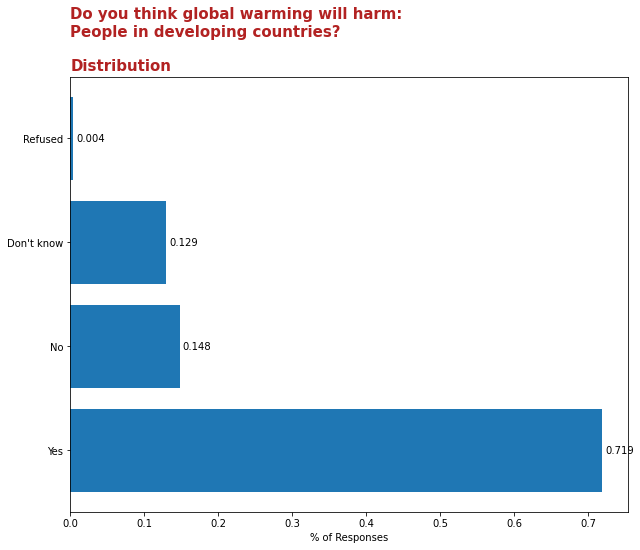

In [37]:
distgraph('harm_dev_countries',
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')

**Observation**
  *  A majority of respondents (71.9%) answered Yes that global warming will harm people in developing countries.
  *  14.8% of respondents answered No
  *  Around 13.3% of respondents either did not know or refused to answer


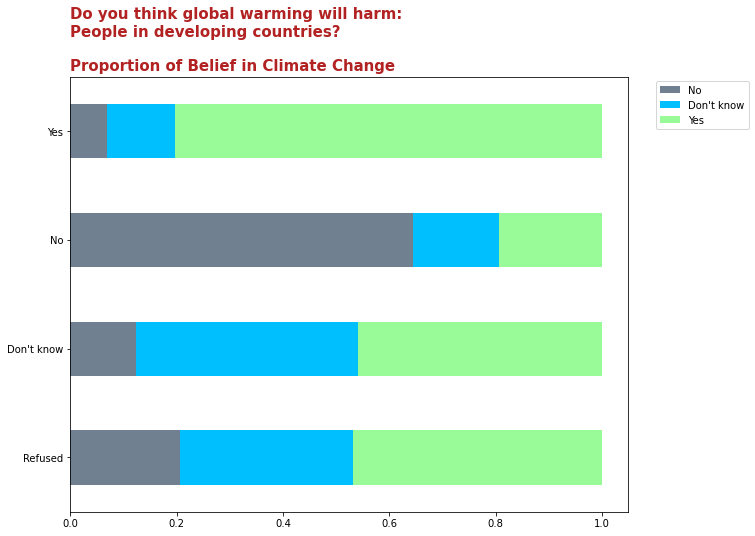

In [38]:
propgraph('harm_dev_countries',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')


  
**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_future_gen`
**How much do you think global warming will harm: Future generations of people**

In [39]:
list(df.harm_future_gen.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [40]:
df.harm_future_gen = df.harm_future_gen.replace({i:j for i,j in my_dict.items()})

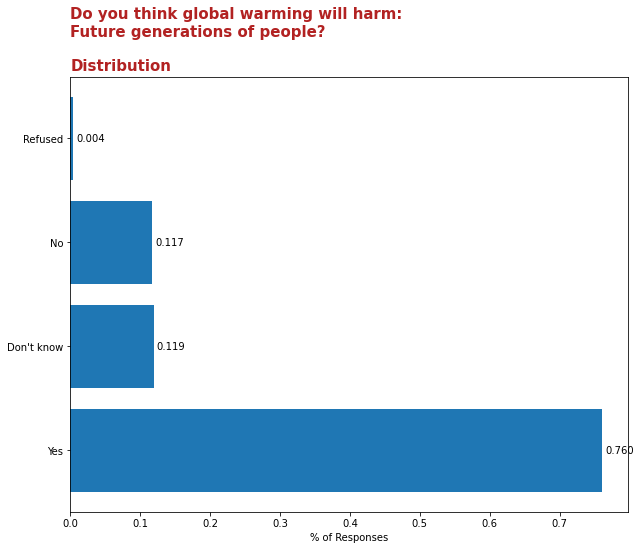

In [41]:
distgraph('harm_future_gen',
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  A majority of respondents (76.0%) answered Yes that global warming will harm future generations of people.
  *  11.9% of respondents answered No
  *  Around 12.1% of respondents either did not know or refused to answer


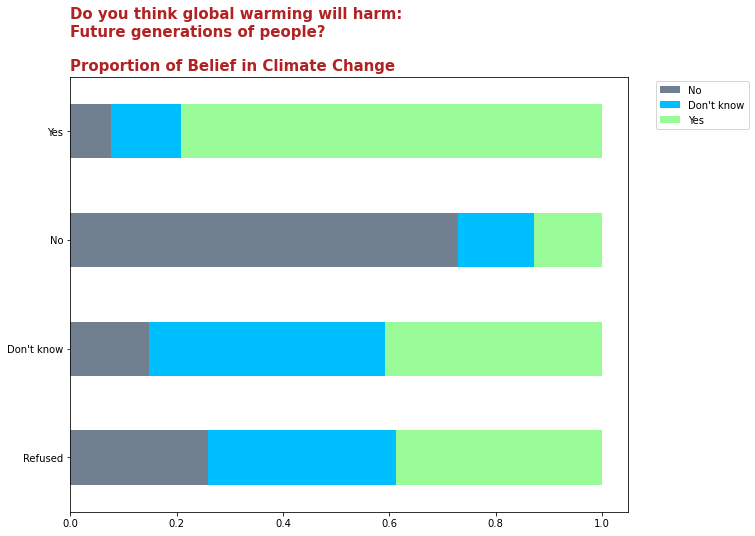

In [42]:
propgraph('harm_future_gen',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_plants_animals`
**How much do you think global warming will harm: Plant and animal species**

In [43]:
df.harm_plants_animals.isnull().sum() / df.shape[0]

0.0595211456701723

6% of respondents were not offered this question as it was not asked in Oct 2015. These will need to be imputed.

In [44]:
list(df.harm_plants_animals.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused',
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [45]:
df.harm_plants_animals = df.harm_plants_animals.replace({i:j for i,j in my_dict.items()})

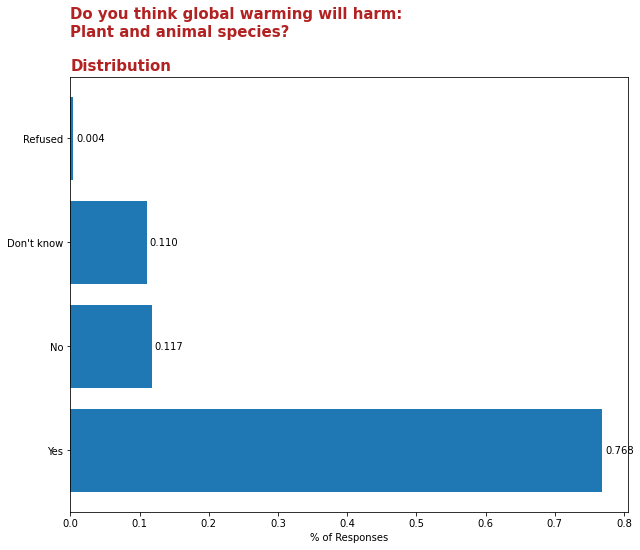

In [46]:
distgraph('harm_plants_animals',
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  A majority of respondents (76.8%) answered Yes that global warming will harm plants and animals.
  *  11.7% of respondents answered No
  *  Around 11.4% of respondents either did not know or refused to answer

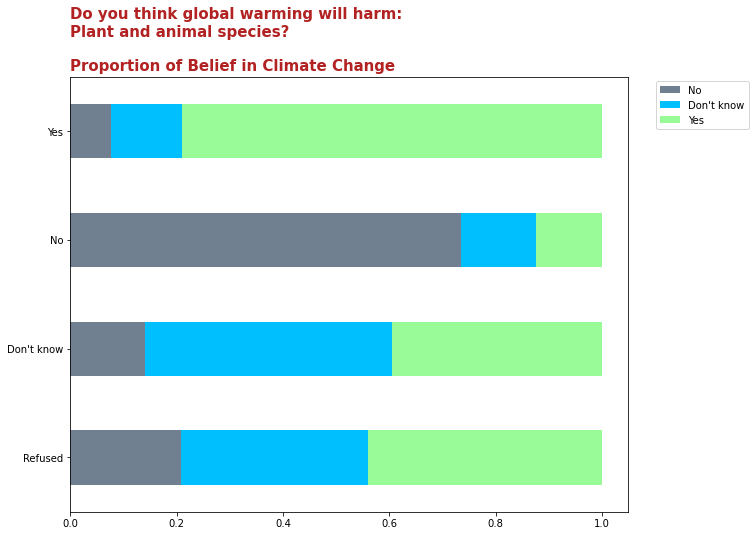

In [47]:
propgraph('harm_plants_animals',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know didn't know if they believe in global warming, closely followed by Yes.
  *  A majority of respondents for Refused believed in global warming.

#### `when_harm_us`
**When do you think global warming will start to harm people in the United States?**

In [48]:
list(df.when_harm_US.unique())

['In 10 years',
 'In 50 years',
 'Never',
 'In 25 years',
 'In 100 years',
 'They are being harmed now',
 'Refused']

The response options. Map these to Refused, Never, In the Future, and Now for more absolute groupings.

In [49]:
my_dict = {'In 10 years': 'In the Future',
           'In 50 years': 'In the Future',
           'Never': 'Never',
           'In 25 years': 'In the Future',
           'In 100 years': 'In the Future',
           'They are being harmed now': 'Now',
           'Refused': 'Refused'}

df.when_harm_US = df.when_harm_US.replace({i:j for i,j in my_dict.items()})

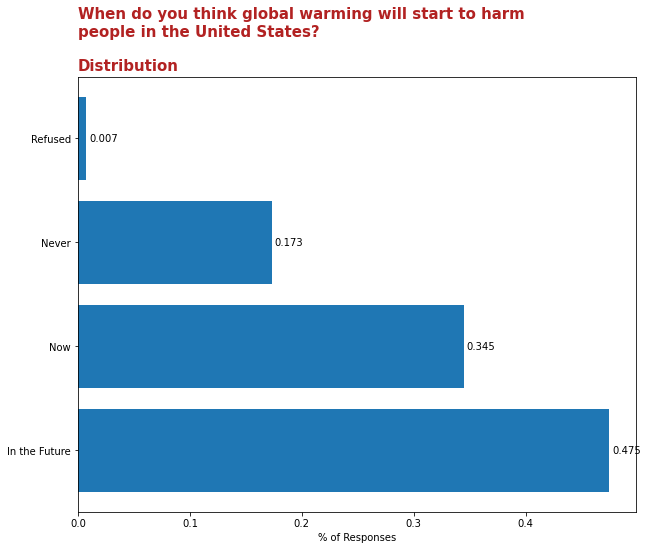

In [50]:
distgraph('when_harm_US',
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  A plurality of respondents (47.5%) answered `In the Future` for when global warming will start to harm people in the United States.
  *  34.5% of respondents answered `Now`
  *  17.3% of respondents answer `Never`

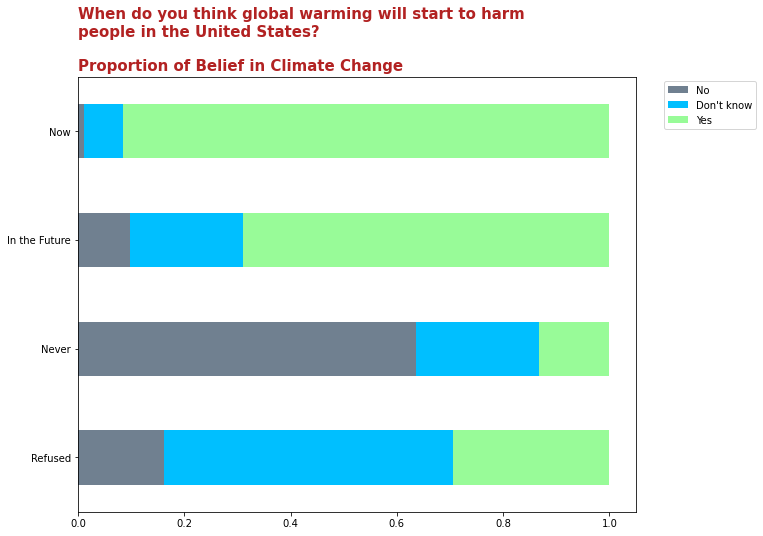

In [51]:
propgraph('when_harm_US',
          ['Refused','Never', 'In the Future','Now'],
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  Unsurprisingly, `Now` and `In the Future` both believe in global warming by a large margin
  *  Respondents for `Never` still held decent amounts of Don't Know and Yes for belief in global warming indicating that global warming may not be inherently harmful in their mind.

#### `reg_CO2_pollutant`
**How much do you support or oppose the following policies?
Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.**

In [52]:
df.reg_CO2_pollutant.isnull().sum()/df.shape[0]

0.04466323562318192

4.5% of respondents were not offered this question as it was not asked in May 2011. These will need to be imputed.

In [53]:
list(df.reg_CO2_pollutant.unique())

['Strongly support',
 'Somewhat support',
 'Somewhat oppose',
 'Strongly oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [54]:
my_dict = {'Strongly support': 'Support',
           'Somewhat support': 'Support',
           'Somewhat oppose': 'Oppose',
           'Strongly oppose': 'Oppose',
           'Refused': 'Refused'}

df.reg_CO2_pollutant = df.reg_CO2_pollutant.replace({i:j for i,j in my_dict.items()})

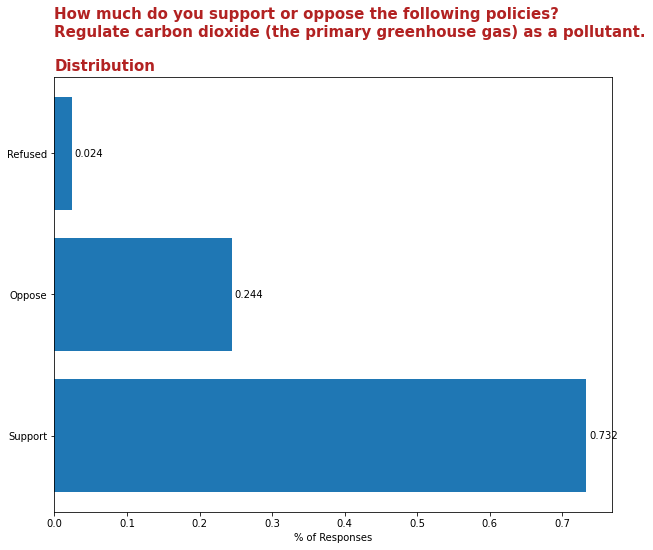

In [55]:
distgraph('reg_CO2_pollutant',
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  A majority of respondents (73.2%) support regulating carbon dioxide.
  *  24.4% of respondents answered No
  *  Around 2.4% of respondents either did not know or refused to answer

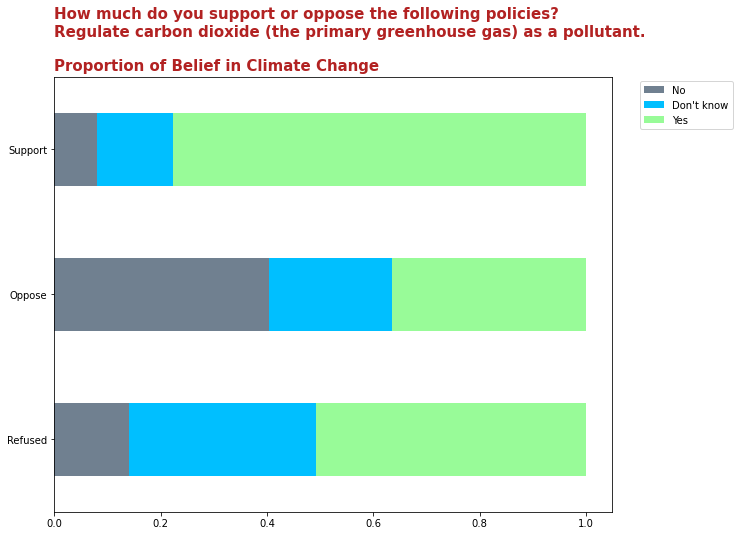

In [56]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_utilities`
**How much do you support or oppose the following policies? Require electric utilities to produce at least 20% of their electricity from wind, solar, or other renewable energy sources, even if it costs the average household an extra $100 a year.**

In [57]:
df.reg_utilities.isnull().sum() / df.shape[0]

0.22492727679570373

22.5% of respondents were not offered this question as it was not asked in Oct 2015, Mar and Nov 2016, and May 2017. These will need to be imputed.

In [58]:
list(df.reg_utilities .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [59]:
df.reg_utilities = df.reg_utilities.replace({i:j for i,j in my_dict.items()})

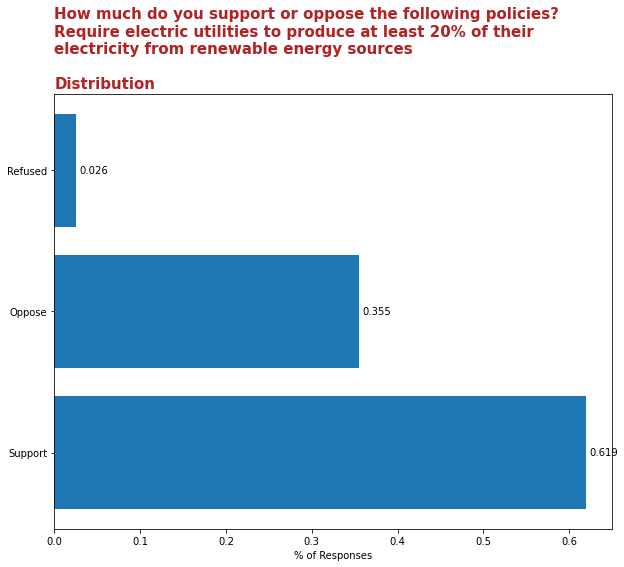

In [60]:
distgraph('reg_utilities',
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  A majority of respondents (61.9%) support requiring electric utilities to produce at least 20% renewable energy.
  *  35.5% of respondents answered No
  *  Around 2.6% of respondents either did not know or refused to answer

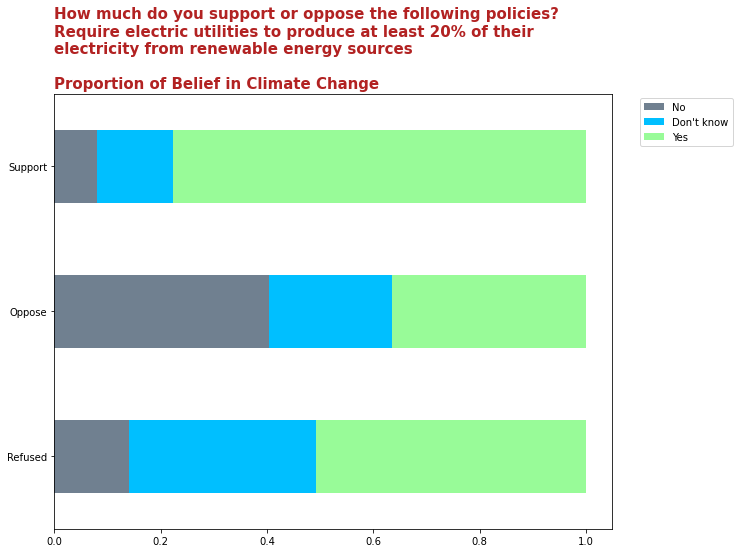

In [61]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `fund_research`
**How much do you support or oppose the following policies? Fund more research into renewable energy sources, such as solar and wind power.**

In [62]:
list(df.fund_research .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused']

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [63]:
df.fund_research = df.fund_research.replace({i:j for i,j in my_dict.items()})

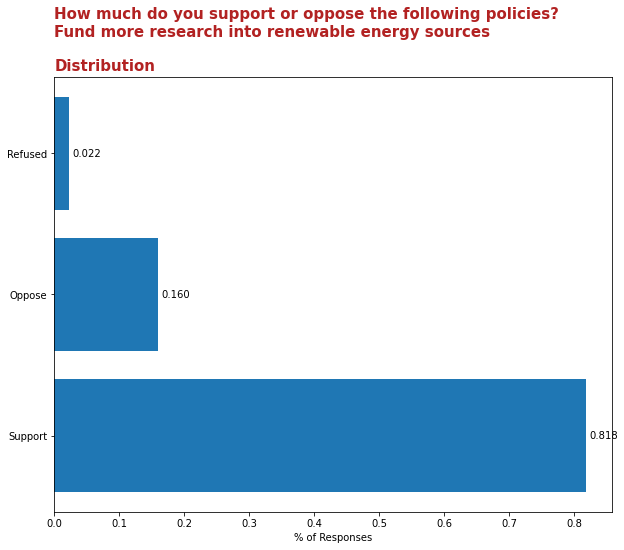

In [64]:
distgraph('fund_research',
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  A majority of respondents (81.8%) support funding more research into renewable energy sources.
  *  16.0% of respondents answered No
  *  Around 2.2% of respondents refused to answer

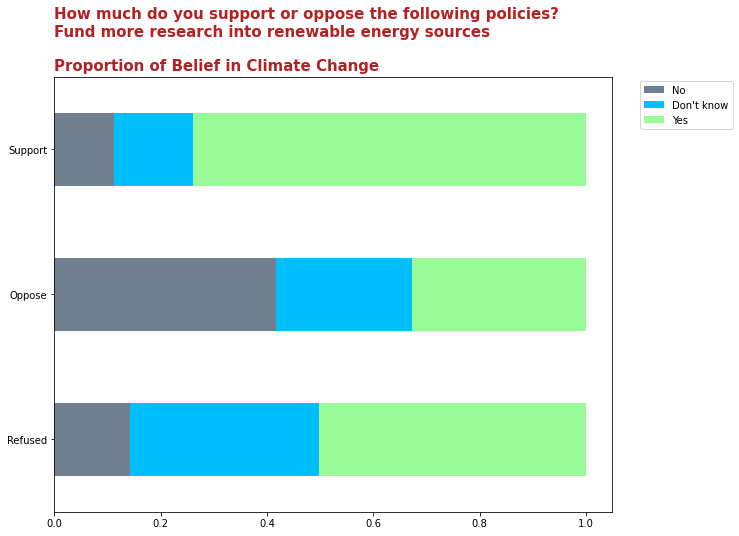

In [65]:
propgraph('fund_research',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_coal_emissions`
**How much do you support or oppose the following policy? Set strict carbon dioxide emission limits on existing coal-fired power plants to reduce global warming and improve public health. Power plants would have to reduce their emissions and/or invest in renewable energy and energy efficiency. The cost of electricity to consumers and companies would likely increase**

In [66]:
df.reg_coal_emissions.isnull().sum() / df.shape[0]

0.4042962631461177

40.4% of respondents were not offered this question as it was not asked between 2008 and 2012, and Nov 2013.

Because of this high amount of missingness, drop the column.

In [67]:
df.drop('reg_coal_emissions', axis = 1, inplace=True)

#### `discuss_GW`
**How often do you discuss global warming with your family and friends?**

In [68]:
list(df.discuss_GW.unique())

['Occasionally', 'Rarely', 'Never', 'Often', 'Refused']

The response options. Map these to Refused, Never, At All for more absolute groupings

In [69]:
my_dict = {'Occasionally': 'At All',
           'Rarely': 'At All',
           'Never': 'Never',
           'Often': 'At All',
           'Refused': 'Refused'}

df.discuss_GW = df.discuss_GW.replace({i:j for i,j in my_dict.items()})

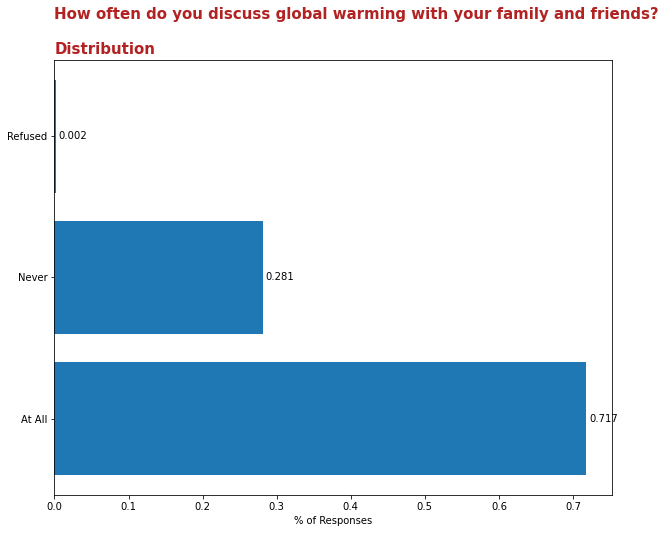

In [70]:
distgraph('discuss_GW',
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  A majority of respondents discuss global warming with family and friends

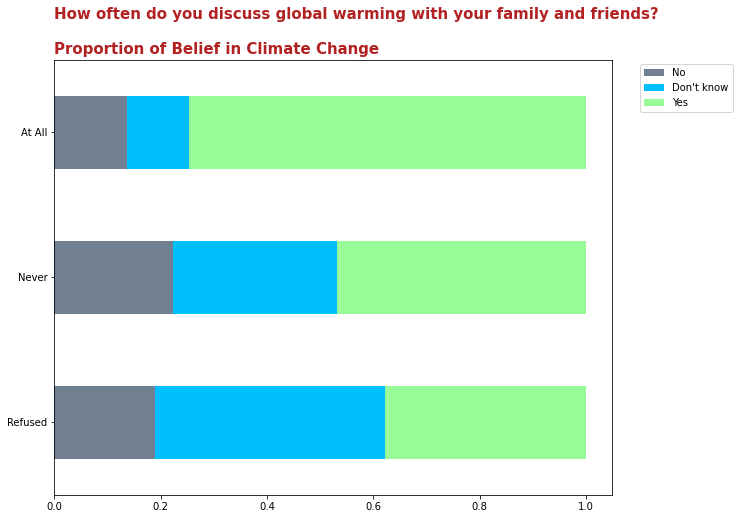

In [71]:
propgraph('discuss_GW',
          ['Refused','Never','At All'],
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  Despite `Never` discussing global warming with family and friends, that group of respondents still believes in global warming on average along with `At All`

#### `hear_GW_media`
**About how often do you hear about global warming in the media (TV, movies, radio, newspapers/news websites, magazines, etc.)?**

In [72]:
df.hear_GW_media.isnull().sum() / df.shape[0]

0.6080554933989707

60.8% of respondents were not offered this question as it was not asked between 2008 and 2014, and Nov 2016.

Because of this high amount of missingness, drop the column.

In [73]:
df.drop('hear_GW_media', axis = 1, inplace=True)

#### `gender`
**Are you Male or Female?**

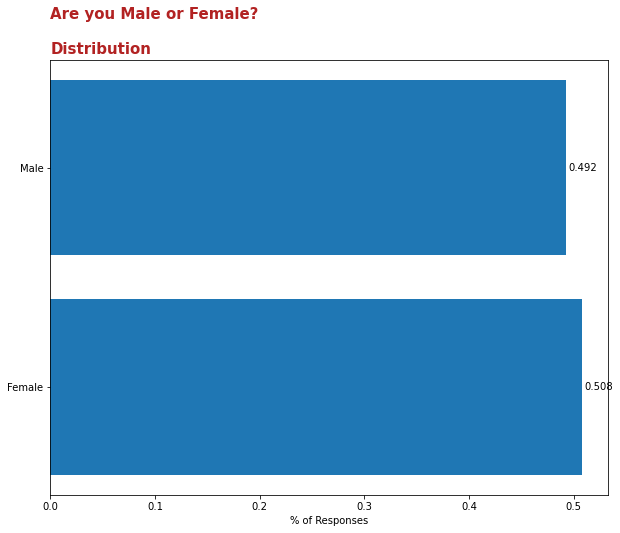

In [74]:
distgraph('gender',
          'Are you Male or Female?')

**Observation**
  *  The distribution of responses is very close to even with `female` representing a majority of responses at 50.8%

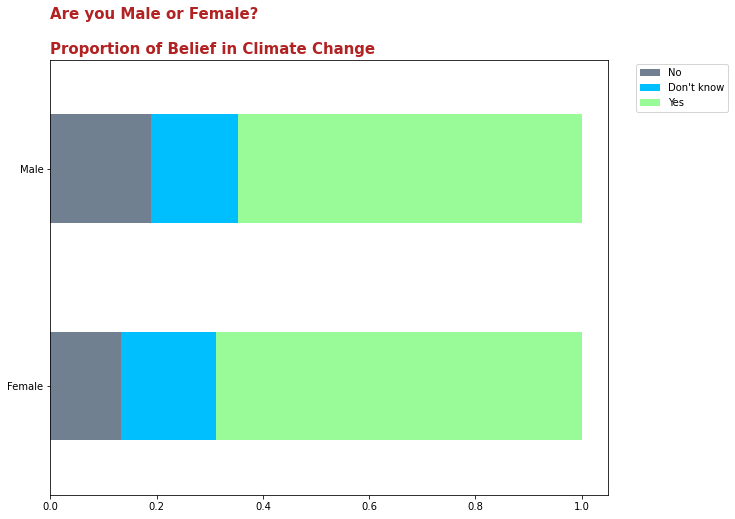

In [75]:
propgraph('gender',
          ['Female','Male'],
          'Are you Male or Female?')

**Observation**
  *  `Female` respondents believed in global warming more than `Male` respondents.

In [76]:
# dummify gender to be 0 for male and 1 for female
df.gender = [int(val == 'Female') for val in df.gender]

#### `age`
**How old are you?**

In [77]:
df.age.describe()

count    22345.000000
mean        50.482166
std         16.805682
min         18.000000
25%         37.000000
50%         52.000000
75%         64.000000
max         97.000000
Name: age, dtype: float64

The range of responses was 18-97 meaning only responses from adults were recorded. The average age was 50 years old.

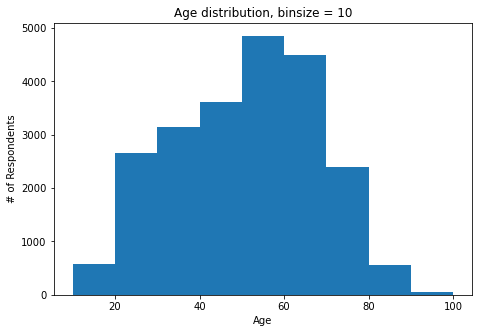

In [78]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax.hist(df.age,
        bins = np.arange(10,101,10))
ax.set_title('Age distribution, binsize = 10')
ax.set_ylabel('# of Respondents')
ax.set_xlabel('Age');

**Observation**
  *  The age distribution is centered around 50, which is also the mean and contains the median value 52.
  *  Right tailed with small amount of respondents in the 90-100 range.
  *  High number of young respondents also making it more skewed.

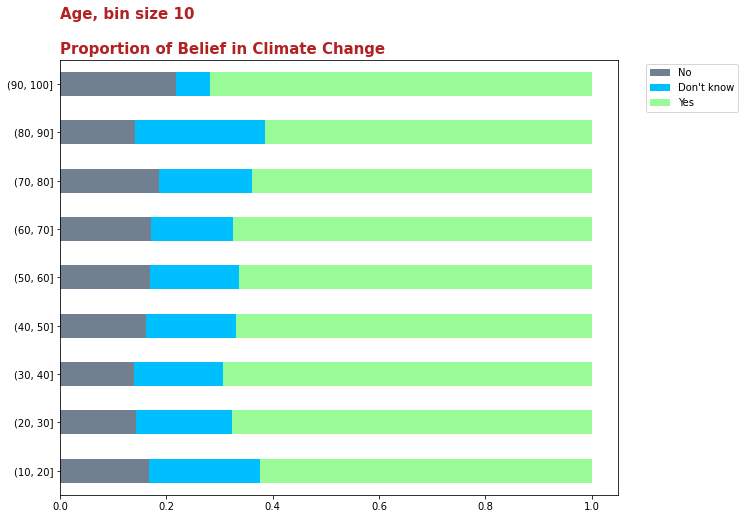

In [79]:
# graph

propgraph(pd.cut(df.age, bins = np.arange(10,101,10)),
          [pd.Interval(10, 20, closed='right'),
           pd.Interval(20, 30, closed='right'),
           pd.Interval(30, 40, closed='right'),
           pd.Interval(40, 50, closed='right'),
           pd.Interval(50, 60, closed='right'),
           pd.Interval(60, 70, closed='right'),
           pd.Interval(70, 80, closed='right'),
           pd.Interval(80, 90, closed='right'),
           pd.Interval(90, 100, closed='right')],
          "Age, bin size 10")

**Observations**
  *  Each age group has a majority of respondents believing in global warming
  *  `20-30` and `30-40` are some of the strongest believers on average
  *  `50-60` was the most popular age bracket for the survey and is one of the softer groups for believing in climate change.

#### `age_category`
**Computed from `age` as a range**

In [80]:
list(df.age_category.unique())

['55+ years', '35-54 years', '18-34 years']

The computed ranges.

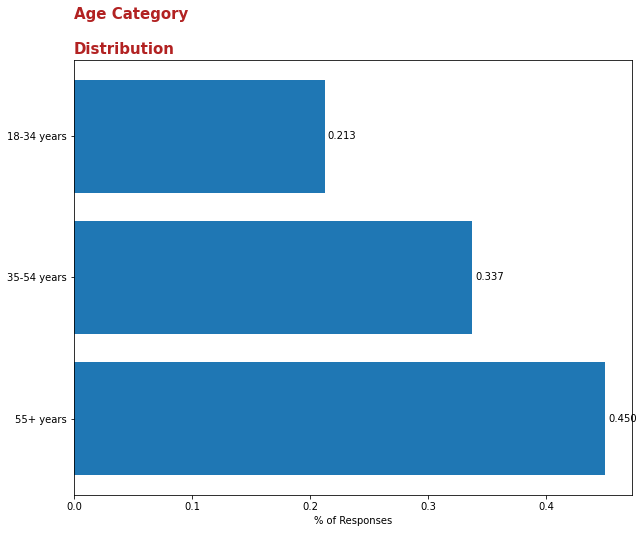

In [81]:
distgraph('age_category',
          'Age Category')

**Observation**
  *  A plurality of respondents are in the 55+ category
  *  The youngest age group is the least represented in the survey

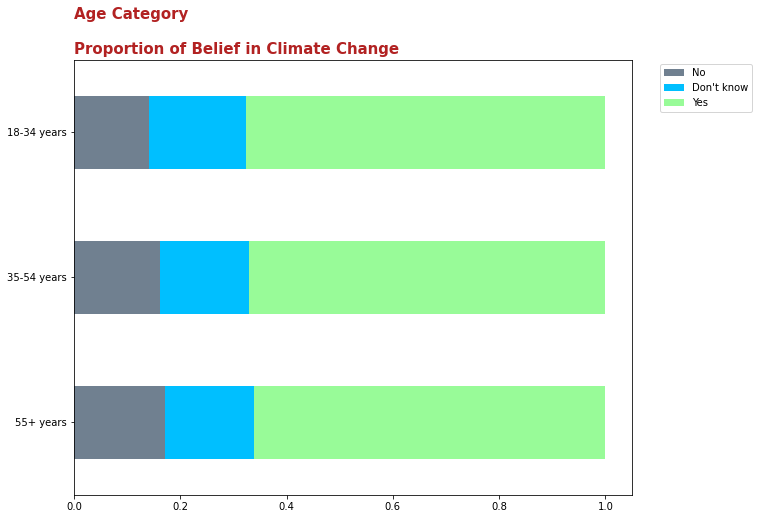

In [82]:
propgraph('age_category',
          ['55+ years','35-54 years','18-34 years'],
          'Age Category')

**Observation**
  *  All three age categories have similar belief proportions.

In [83]:
# dummify age_category and drop 18-34 years as an option
df = df.join(pd.get_dummies(df.age_category, prefix='age_category', 
                            drop_first=True))

# rename the new dummy columns to represent their value
df.rename(columns = {df.columns[-2]:'age_category_35_54', 
                     df.columns[-1]: 'age_category_55_plus'}, 
          inplace=True)

#drop age_category
df.drop('age_category', axis=1, inplace=True)